# Test Benchmarking

This file is to test some benchmarking of the $\mathcal{O}(n^2)$ implementation of the t-SNE algorithm depending on the data type (single or double precision).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Customize matplotlib
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

Plotting function.

In [2]:
def plot(x, y, labels=None, title=None, ylim=2, 
         legend=True):

    lw = 2
    marker = "s"
    markersize = 8
    labels_fontsize = 12
    fontsize = 20
    xlabel = "n"
    ylabel = "flop/cycle"

    fig = plt.figure()
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=.88, left=0, right=1)

    y = np.array(y)
    if len(y.shape) == 1:
        ax.plot(x, y, linewidth=lw, marker=marker, markersize=markersize)
    else:
        assert type(labels) in (list, tuple)
        assert len(labels) == len(y)
        
        for i, l in enumerate(labels):
            ax.plot(x, y[i], linewidth=lw, marker=marker, markersize=markersize, label=l)
    ax.set_ylim([0, ylim])
    if legend:
        ax.legend()

    ax.set_xlim([N.min(), N.max()])
    ax.set_xlabel(xlabel, fontsize=labels_fontsize)

    # For runtime plots where on the yaxis there is an exponent, place the text on the axis title
    ax.ticklabel_format(axis='y', style='sci')
    plt.draw()
    if ax.yaxis.get_offset_text().get_text() != '':
        ax.yaxis.major.formatter._useMathText = True
        plt.draw()
        exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
        ax.yaxis.offsetText.set_visible(False)

    exponent_text = ''
    if title:
        ax.set_title('[{}]{}'.format(ylabel, exponent_text), fontsize=labels_fontsize, 
                     position=(0,1.0), ha='left', va='bottom')

    ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
    ax.set_facecolor('#eeeeee')
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    return ax

Read the data.

In [3]:
start = 200
stop = 3000
interval = 200

input_size = np.arange(start, stop+1, interval)
iters_d = np.loadtxt("../implementations/tsne_exact_optimizations/benchmarking/20170503_121229@-O3 -march=native -std=c++11@double@iters.txt")
iters_f = np.loadtxt("../implementations/tsne_exact_optimizations/benchmarking/20170503_121229@-O3 -march=native -std=c++11@float@iters.txt")
cycles_d = np.loadtxt("../implementations/tsne_exact_optimizations/benchmarking/20170503_121229@-O3 -march=native -std=c++11@double@cycles.txt")
cycles_f = np.loadtxt("../implementations/tsne_exact_optimizations/benchmarking/20170503_121229@-O3 -march=native -std=c++11@float@cycles.txt")

assert np.all(cycles_d[:,:-1].sum(axis=1) == cycles_d[:,-1])
assert np.all(cycles_f[:,:-1].sum(axis=1) == cycles_f[:,-1])

In [4]:
print(iters_d)
print(iters_f)

[  4091.   8268.  12401.  16424.  20592.  24658.  28704.  32859.  36747.
  40793.  44840.  48791.  52854.  56859.  60759.]
[  4084.   8291.  12464.  16465.  20624.  24661.  28805.  32871.  36859.
  40841.  44906.  48971.  52981.  56909.  60991.]


Now compute the flops operations.

In [5]:
N = input_size.astype("float")
it_d = iters_d.astype("float")
it_f = iters_f.astype("float")
D = 28 * 28
d = 2
T = 1000   # Number of iterations

count_measure=("add", "mult", "div", "exp", "log")

Define some auxiliar functions.

In [6]:
def sum_operations_by_measure(flops):
    flops_count = dict()
    #for measure in count_measure:
    #    flops_count[measure] = 
    
    for k, v in flops.items(): 
        for op, cycles in v.items():
            if op not in flops_count:
                flops_count[op] = cycles.copy()
            else:
                flops_count[op] += cycles.copy()
                
    return flops_count

def sum_operations(flops):
    flops_count = None
    for k, v in flops.items():
        if flops_count is None:
            flops_count = v.copy()
        else:
            flops_count += v.copy()
    return flops_count

def sum_operations_by_function(flops, function_list=("normalize", "compute_pairwise_affinity_perplexity",
                                                    "symmetrize_affinities", "early_exageration",
                                                    "compute_low_dimensional_affinities", 
                                                    "gradient_computation", "gradient_update", 
                                                    "normalize_2"), size=N.shape[0]):
    flops_count = np.zeros((size, len(function_list)), dtype="float")
    
    for i, func in enumerate(function_list):
        flops_count[:,i] += sum_operations(flops[func])
    return flops_count

In [7]:
def get_flops(N, it, D, d):
    flops = {
        "normalize": {
            "add": 2 * N * D,
            "div": D + N * D
        },
        "compute_pairwise_affinity_perplexity": {
            "compute_squared_euclidean_distance": {
                "add": D * N*(N-1)/2 * 2,
                "mult": D * N*(N-1)/2
            },
            "binary_search": {
                "add": it * (N + N + 1 + 1),
                "mult": it * (N + 2*N),
                "div": it * (1 + 1) + N * N,
                "exp": it * N,
                "log": it * (1 + 1)
            }
        },
        "symmetrize_affinities": {
            "add": N*(N-1)/2 + N*N,
            "div": N*N
        },
        "early_exageration": {
            "mult": 2 * N*N
        },
        "compute_low_dimensional_affinities": {
            "compute_squared_euclidean_distance": {
                "add": T * d * N*(N-1)/2 * 2,
                "mult": T * d * N*(N-1)/2
            },
            "compute": {
                "add": T * N * (N-1) * 2,
                "div": T * N * (N-1)
            }
        },
        "gradient_computation": {
            "add": T * N * (N-1) * (1 + 2*d),
            "mult": T * N * (N-1) * (1+d),
            "div": T * N * (N-1)
        },
        "gradient_update": {
            "add": T * (N*d + N * d * 2),
            "mult": T * N * d * 3
        },
        "normalize_2": {
            "add": T * 2 * N * d,
            "div": T * (d + N * d)
        }
    }
    return flops

# Reduce the previous dictionary to the main functions which cycles have been counted.
flops_by_function_measure_d = get_flops(N, it_d, D, d)
flops_by_function_measure_d["compute_pairwise_affinity_perplexity"] = \
    sum_operations_by_measure(flops_by_function_measure_d["compute_pairwise_affinity_perplexity"])
flops_by_function_measure_d["compute_low_dimensional_affinities"] = \
    sum_operations_by_measure(flops_by_function_measure_d["compute_low_dimensional_affinities"])
flops_by_function_d = sum_operations_by_function(flops_by_function_measure_d)

flops_by_function_measure_f = get_flops(N, it_f, D, d)
flops_by_function_measure_f["compute_pairwise_affinity_perplexity"] = \
    sum_operations_by_measure(flops_by_function_measure_f["compute_pairwise_affinity_perplexity"])
flops_by_function_measure_f["compute_low_dimensional_affinities"] = \
    sum_operations_by_measure(flops_by_function_measure_f["compute_low_dimensional_affinities"])
flops_by_function_f = sum_operations_by_function(flops_by_function_measure_f)

Compute the total number of flops.

In [8]:
flops_d = sum_operations_by_measure(flops_by_function_measure_d)
flops_d = sum_operations(flops_d)
print(flops_d)
flops_f = sum_operations_by_measure(flops_by_function_measure_f)
flops_f = sum_operations(flops_f)
print(flops_f)

[  6.53031630e+08   2.61060579e+09   5.87256609e+09   1.04384369e+10
   1.63093538e+10   2.34840589e+10   3.19628743e+10   4.17469671e+10
   5.28326668e+10   6.52241145e+10   7.89198059e+10   9.39183471e+10
   1.10222639e+11   1.27830227e+11   1.46740056e+11]
[  6.53023188e+08   2.61066113e+09   5.87279327e+09   1.04386340e+10
   1.63095460e+10   2.34840806e+10   3.19637233e+10   4.17470824e+10
   5.28338770e+10   6.52246908e+10   7.89206775e+10   9.39209402e+10
   1.10224621e+11   1.27831067e+11   1.46744233e+11]


In [9]:
perf_d = flops_d / cycles_d[:,-1]
print(perf_d)

perf_f = flops_f / cycles_f[:,-1]
print(perf_f)

[ 0.74142913  0.73182152  0.72114357  0.64479756  0.70860796  0.67513486
  0.69095915  0.6170266   0.67604987  0.64904635  0.64154521  0.61615637
  0.62810661  0.62266666  0.62652802]
[ 0.71990176  0.71988041  0.71959052  0.64164122  0.47183117  0.56435285
  0.6794514   0.65238965  0.67213234  0.65885604  0.65887842  0.63806167
  0.64430732  0.64095711  0.63960158]


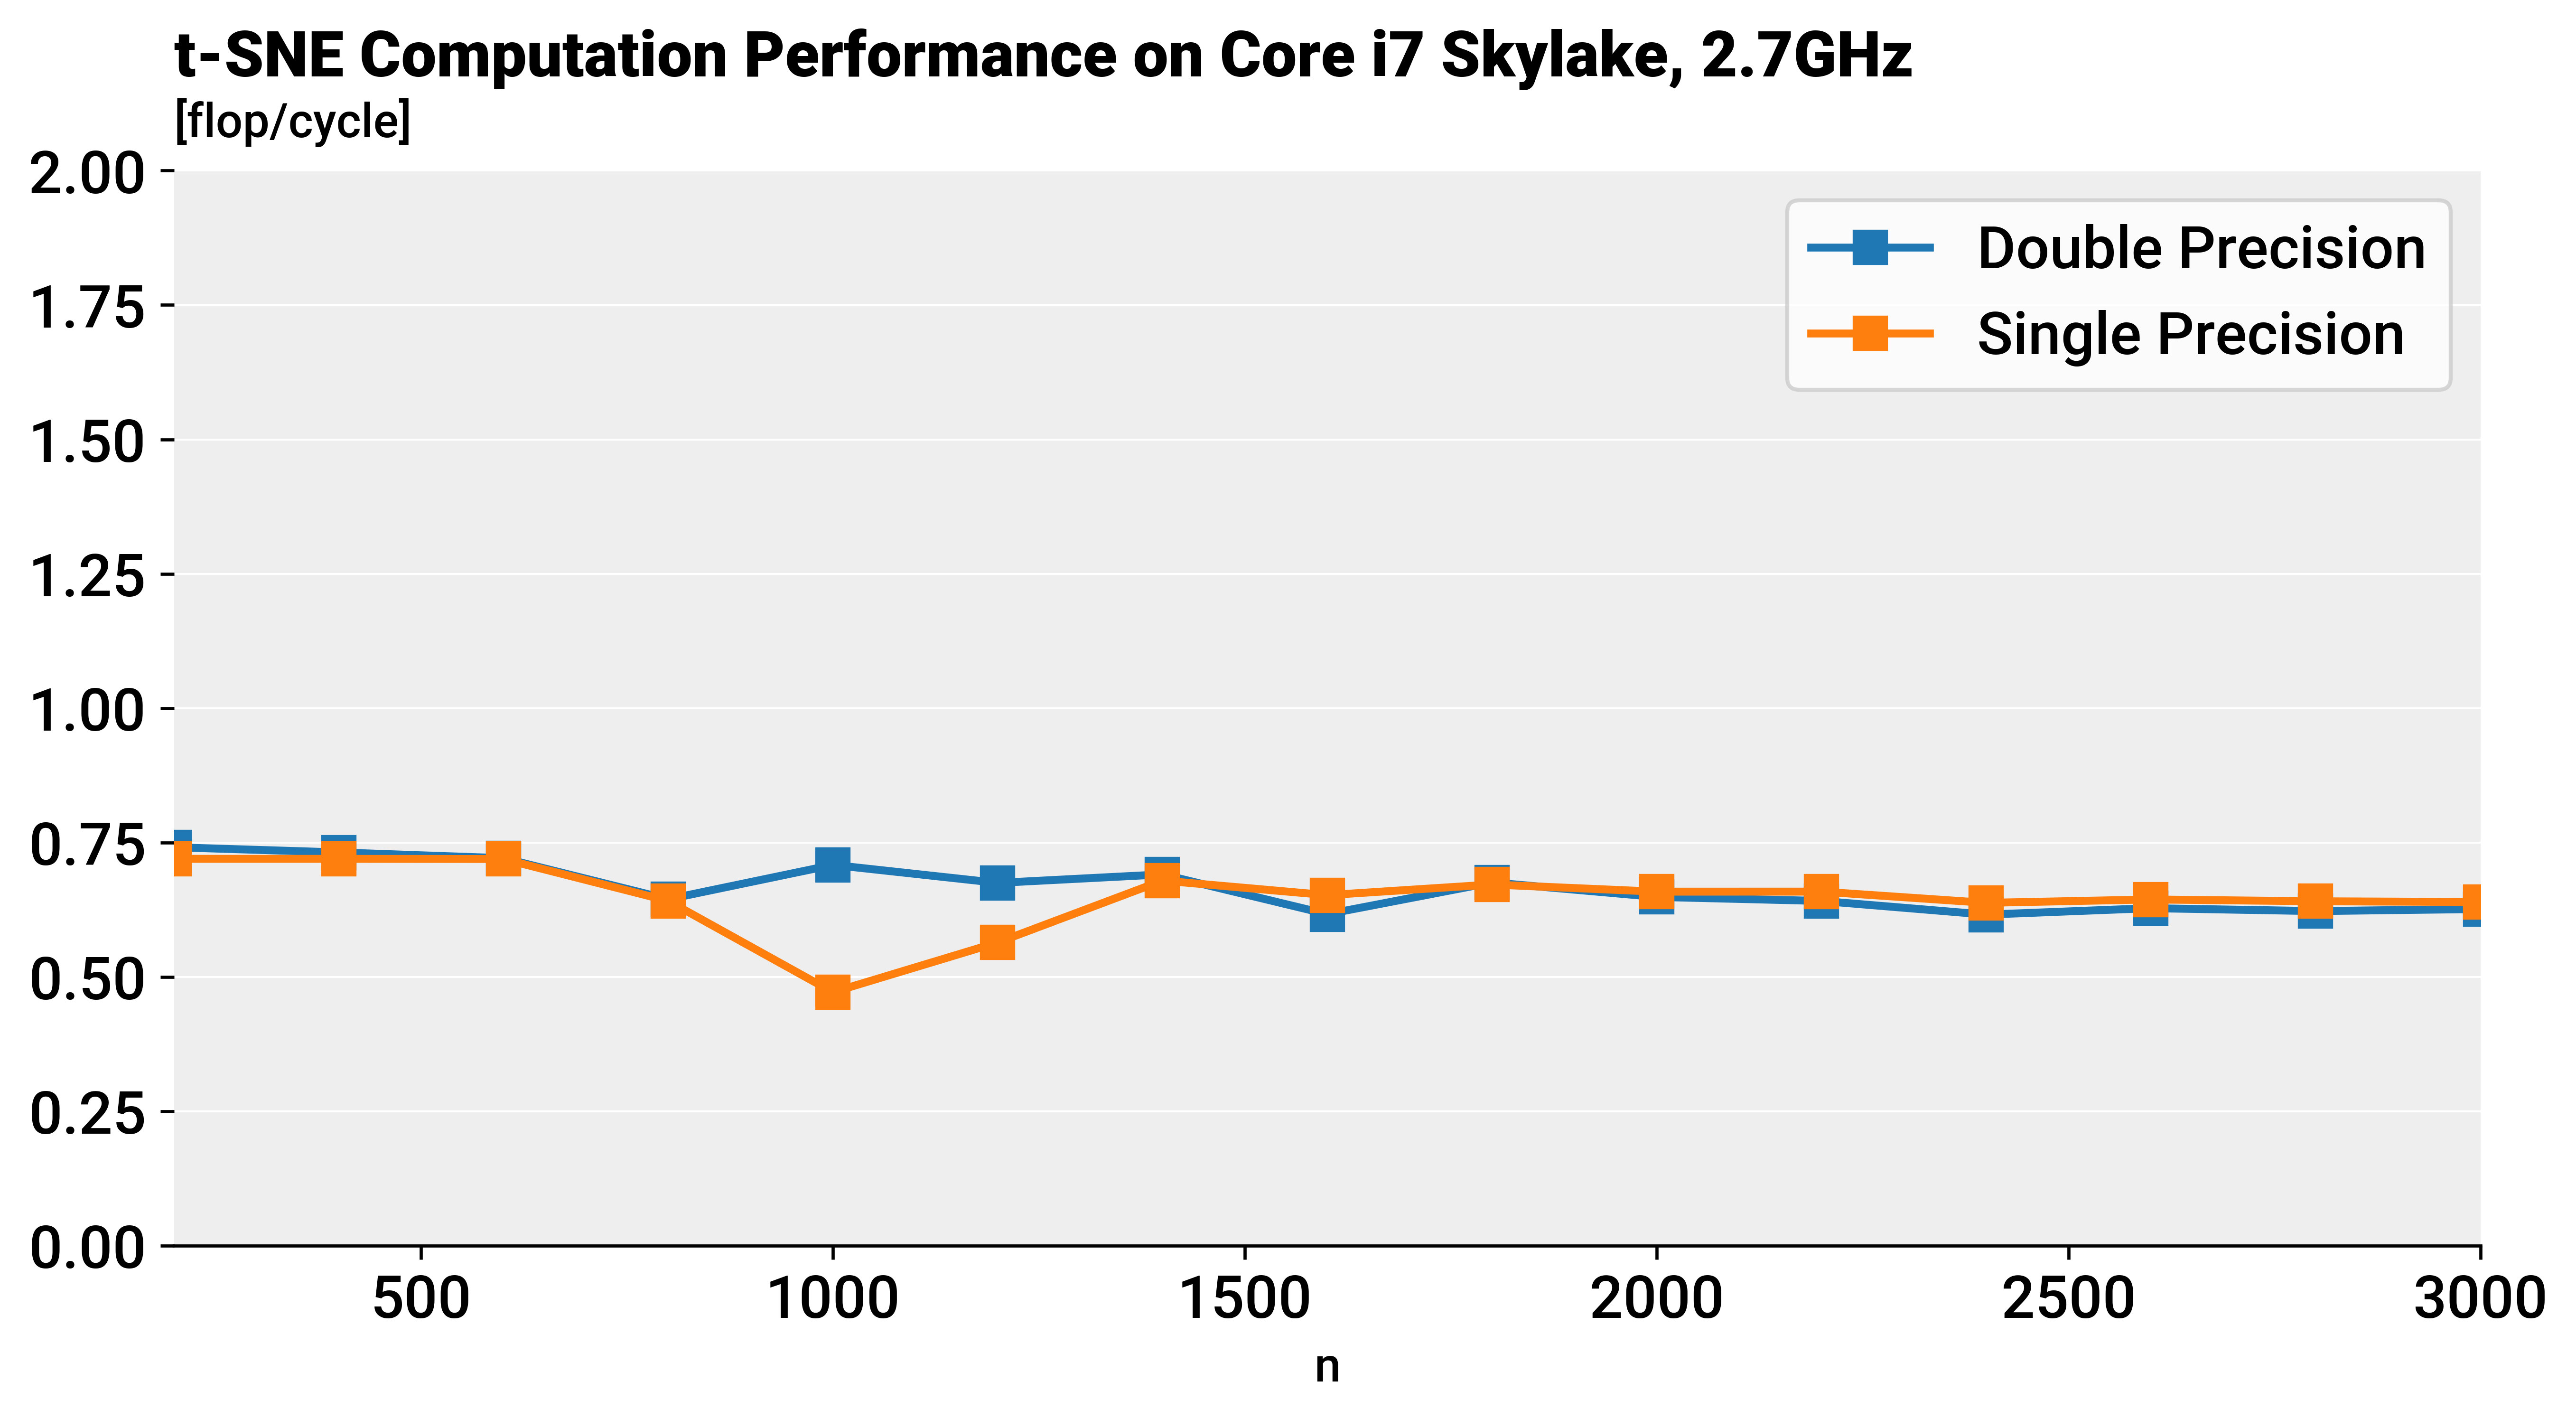

In [10]:
title = "t-SNE Computation Performance on Core i7 Skylake, 2.7GHz"
plot(N, [perf_d, perf_f], title=title, labels=["Double Precision", "Single Precision"])
plt.show()

Now observe the performance by function.

In [11]:
function_list=("normalize", "compute_pairwise_affinity_perplexity", "symmetrize_affinities", 
               "early_exageration", "compute_low_dimensional_affinities", "gradient_computation", 
               "gradient_update", "normalize_2")

perf_func_d = flops_by_function_d / cycles_d[:,:-1]
perf_func_f = flops_by_function_f / cycles_f[:,:-1]

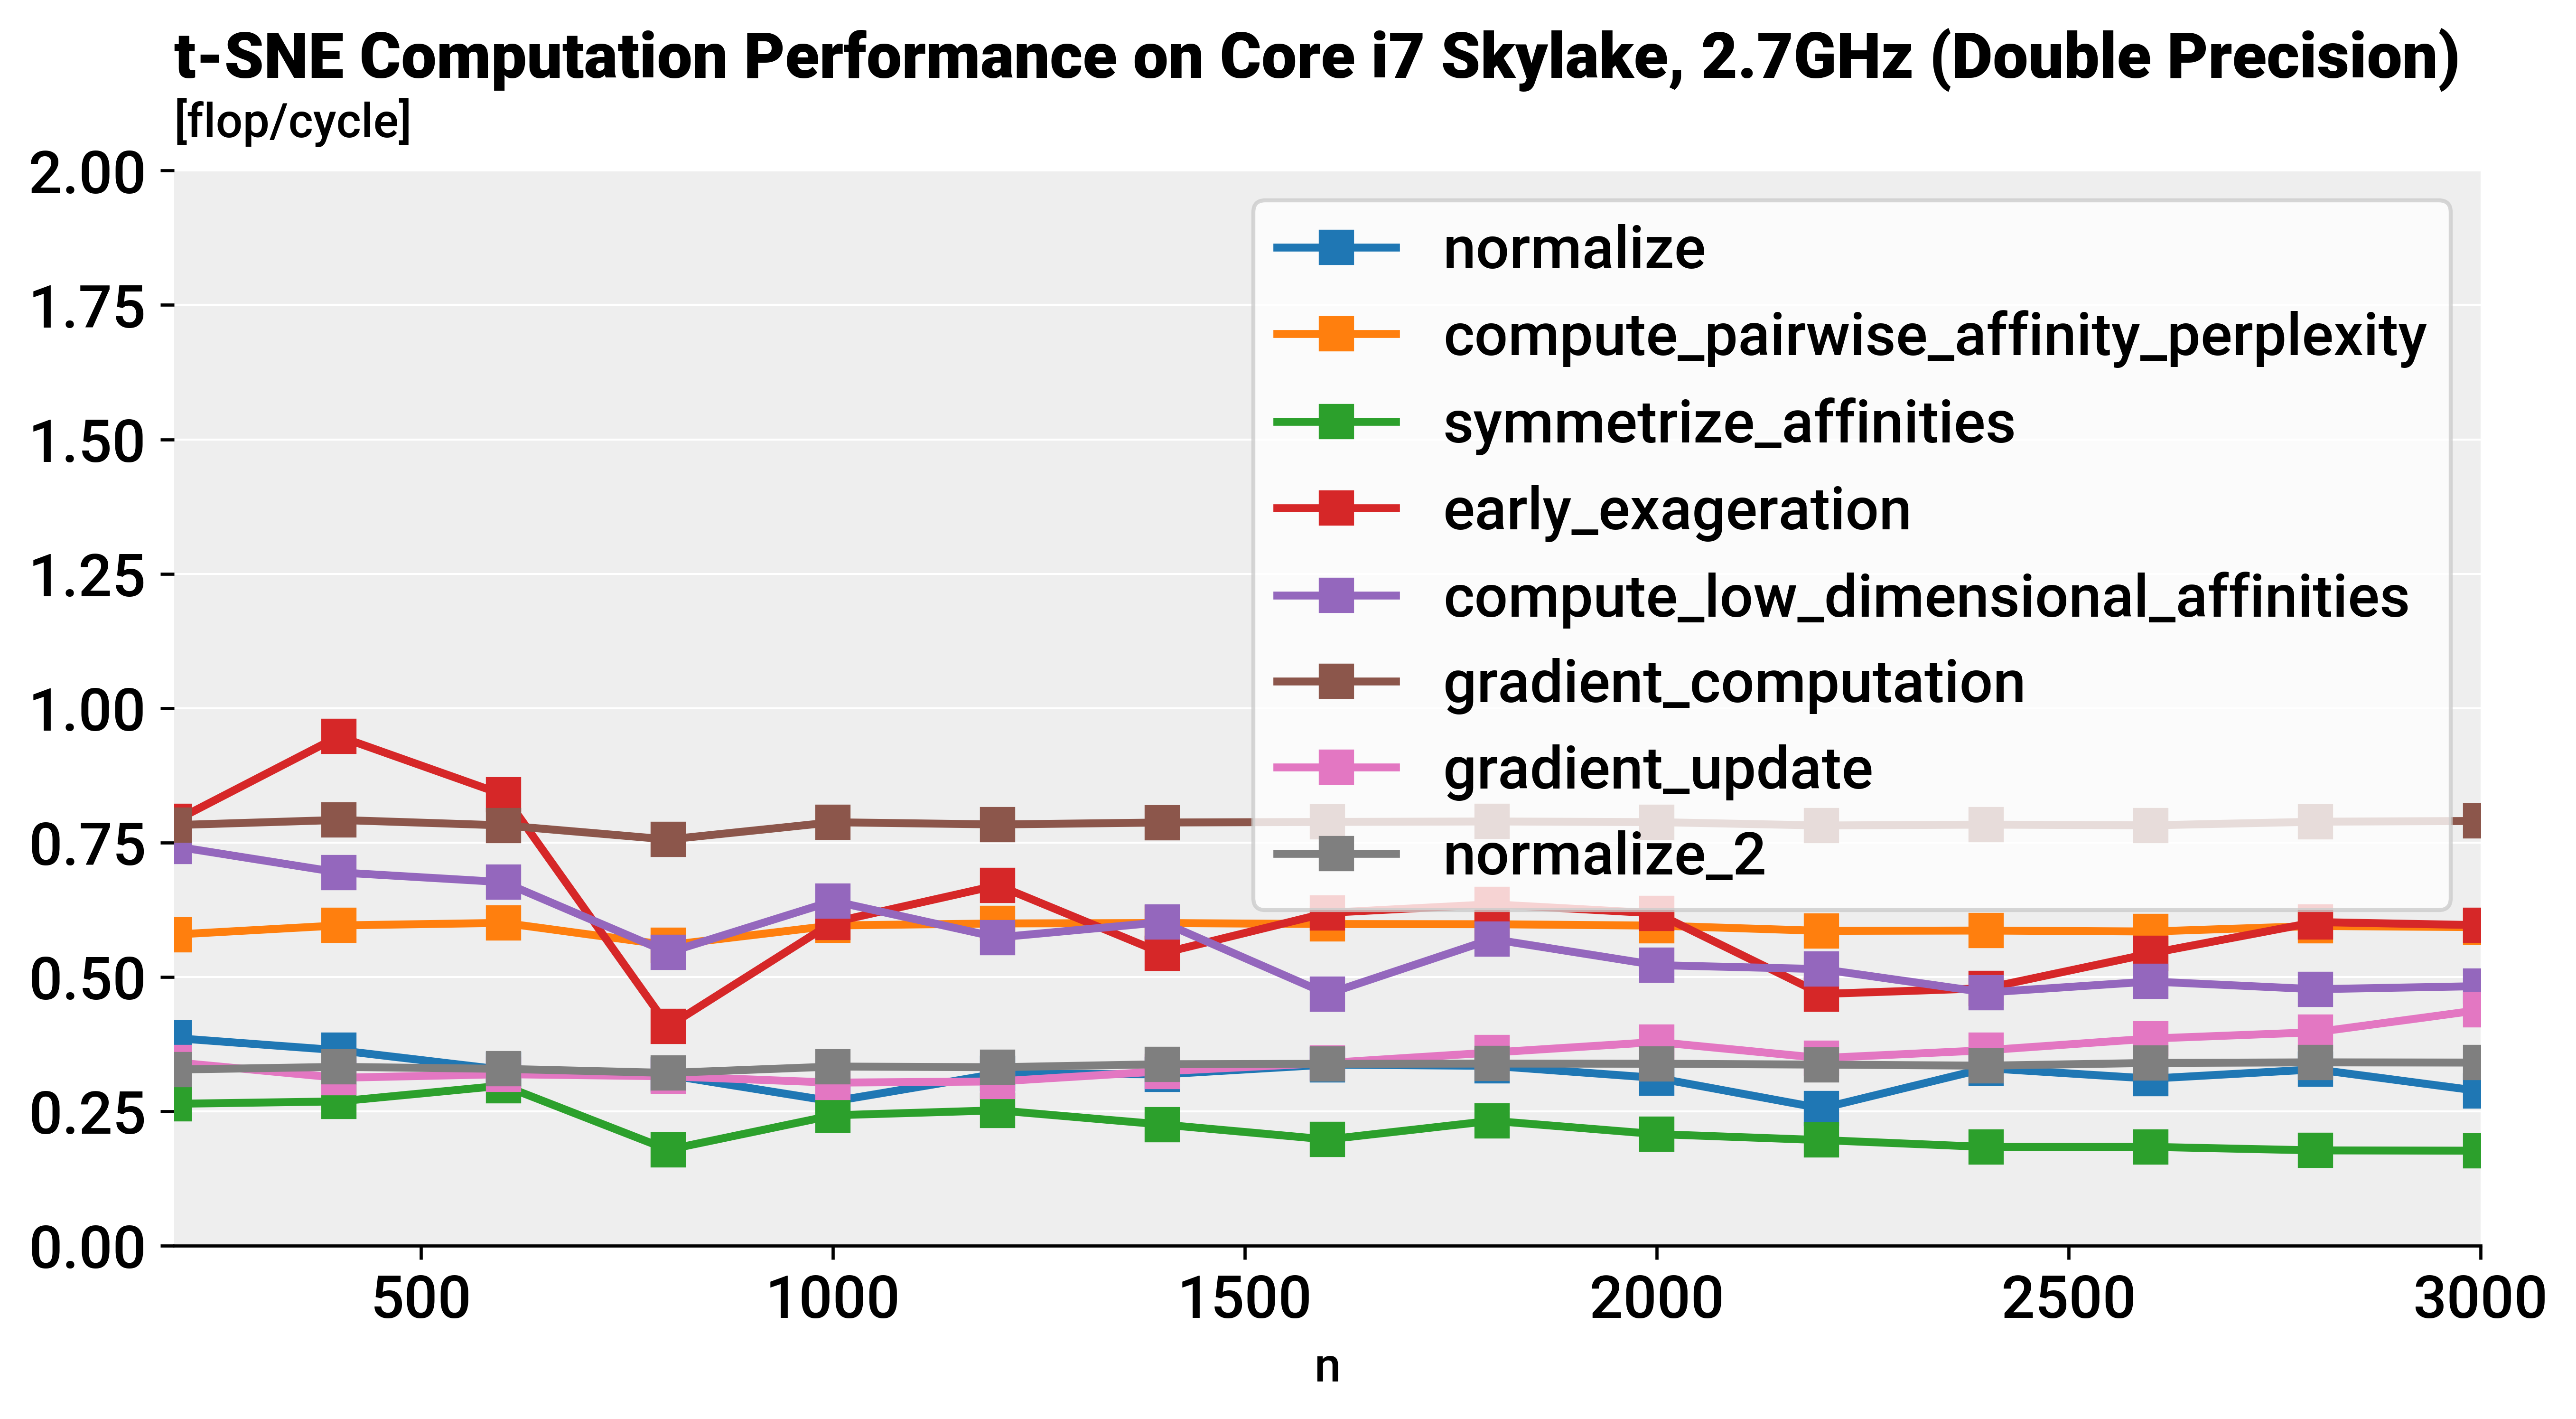

In [12]:
title = "t-SNE Computation Performance on Core i7 Skylake, 2.7GHz (Double Precision)"
plot(N, perf_func_d.T, title=title, labels=function_list)
plt.show()

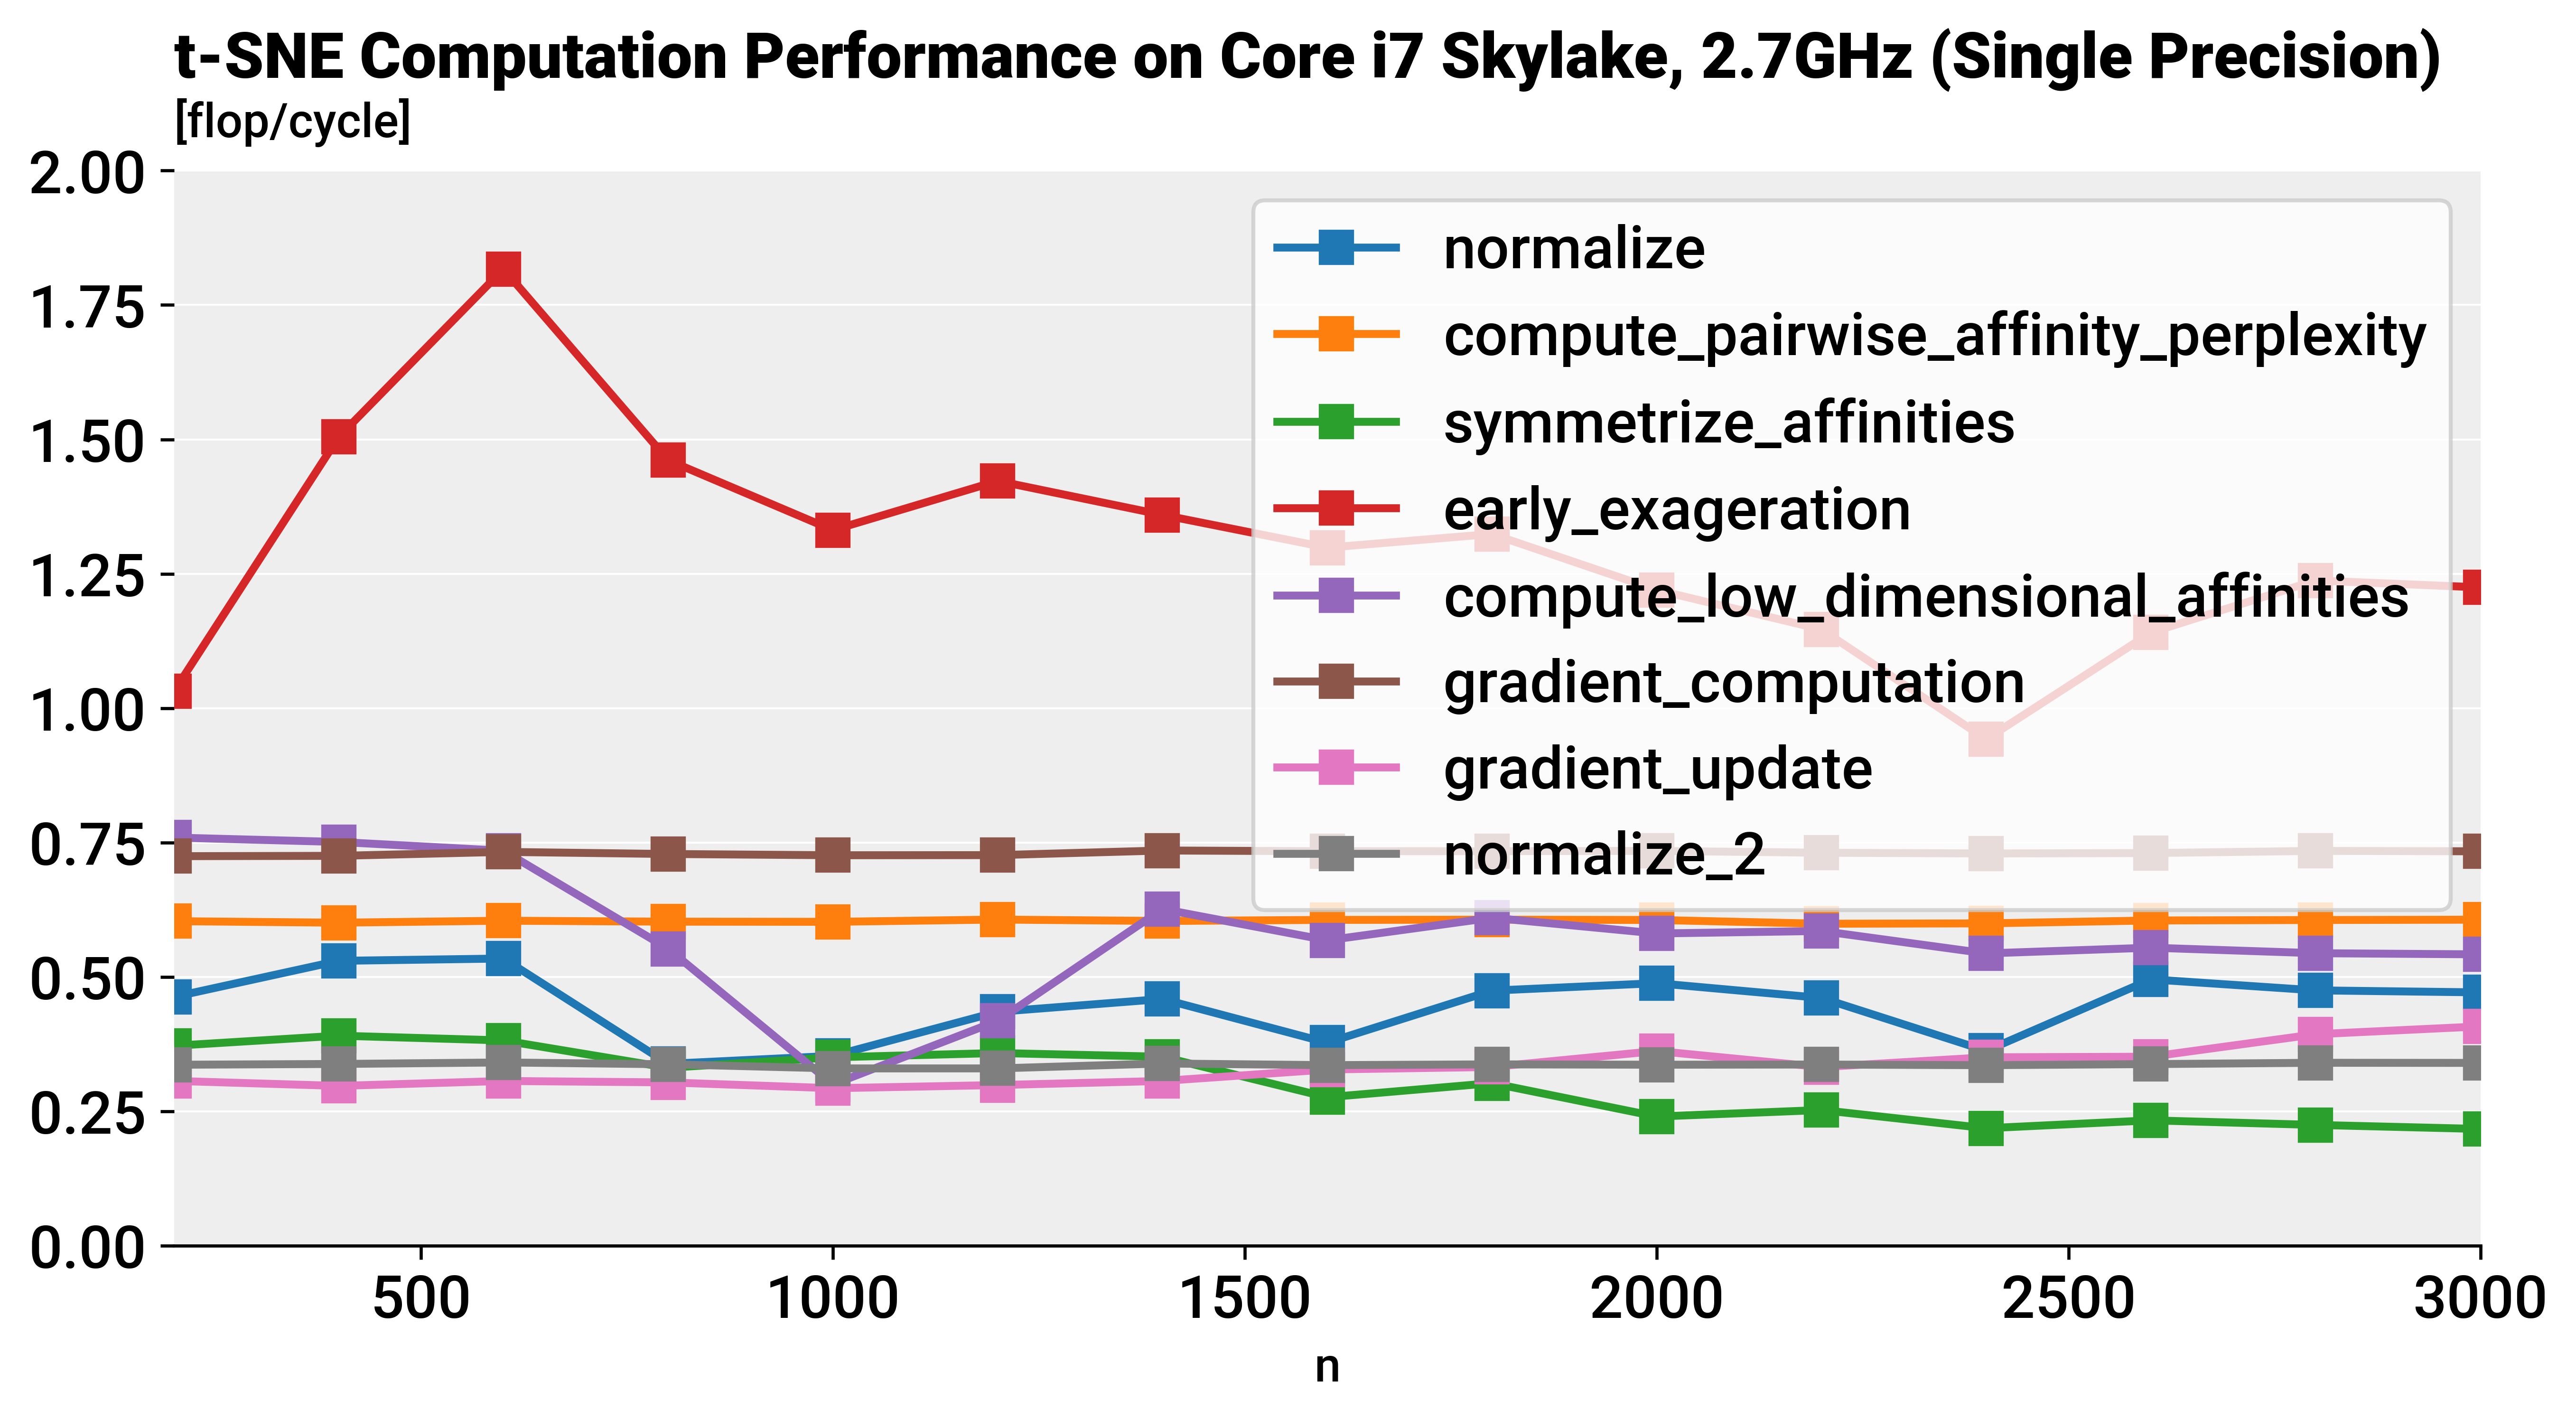

In [13]:
title = "t-SNE Computation Performance on Core i7 Skylake, 2.7GHz (Single Precision)"
plot(N, perf_func_f.T, title=title, labels=function_list)
plt.show()